Group 28

Ramzi Yakan

ryaka009@uottawa.ca

300078504

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotly import tools
import plotly.graph_objs  as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(42)

##### Data loading and exploratory analysis

In [81]:
# tested top 5 stocks (+ a few other notable ones): SNAP, TWTR, AAPL, AMD, T, NVDA, F, NFLX,
df = pd.read_csv('Stocks/aapl.us.txt')

# only using data since start of 2010, so drop the rest (but first, we have to convert the date data into a dropable format)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# now we can easily drop unwanted data
date_split = '2010-01-01'
data = df[date_split:]

# see names of columns (they are the same for all stocks)
print(data.columns)
print(data.info())
print(data.index.min(), data.index.max())
print(data.head())

# After viewing the CSV files and performing my first few experiments, I realized OpenInt and Volume columns were useless to me, so remove those columns
data = data.drop(columns=['OpenInt', 'Volume'])


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2010-01-04 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1980 non-null   float64
 1   High     1980 non-null   float64
 2   Low      1980 non-null   float64
 3   Close    1980 non-null   float64
 4   Volume   1980 non-null   int64  
 5   OpenInt  1980 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 108.3 KB
None
2010-01-04 00:00:00 2017-11-10 00:00:00
              Open    High     Low   Close     Volume  OpenInt
Date                                                          
2010-01-04  27.341  27.470  27.199  27.406  137045797        0
2010-01-05  27.508  27.609  27.310  27.454  167718021        0
2010-01-06  27.454  27.563  26.990  27.017  153403690        0
2010-01-07  27.108  27.148  26.772  26.968  132861904        0
2010-01-08  26.946  

##### LTSM Model

Train length: 1510
              Open    High     Low   Close
Date                                      
2010-01-04  27.341  27.470  27.199  27.406
2010-01-05  27.508  27.609  27.310  27.454
2010-01-06  27.454  27.563  26.990  27.017
2010-01-07  27.108  27.148  26.772  26.968
2010-01-08  26.946  27.148  26.774  27.147
Test length: 470
               Open     High     Low    Close
Date                                         
2016-01-04   98.786  101.460  98.211  101.440
2016-01-05  101.810  101.910  98.597   98.885
2016-01-06   96.816   98.558  96.149   96.949
2016-01-07   95.003   96.400  92.839   92.857
2016-01-08   94.879   95.417  93.157   93.349
Train data:


Test data:


Epoch 1/5
1500/1500 - 2s - loss: 0.0176
Epoch 2/5
1500/1500 - 2s - loss: 0.0145
Epoch 3/5
1500/1500 - 2s - loss: 0.0139
Epoch 4/5
1500/1500 - 2s - loss: 0.0139
Epoch 5/5
1500/1500 - 2s - loss: 0.0135


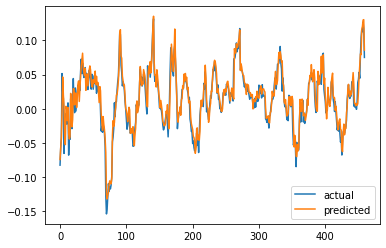

The Mean Absolute Error is: 0.009628211637259342


In [82]:
# For this model, I decided that everything since the start of 2016 should be the test data; everything before is the training data
date_split = '2016-01-01'
train_LTSM = data[:date_split]
test_LTSM = data[date_split:]
print("Train length:" , len(train_LTSM))
print(train_LTSM.head())
print("Test length:" , len(test_LTSM))
print(test_LTSM.head())

# Plot the data
print("Train data:")
fig = go.Figure(data=[go.Candlestick(
    x=train_LTSM.index,
    open=train_LTSM['Open'],
    high=train_LTSM['High'],
    low=train_LTSM['Low'],
    close=train_LTSM['Close'])])
fig.show()

print("Test data:")
fig = go.Figure(data=[go.Candlestick(
    x=test_LTSM.index,
    open=test_LTSM['Open'],
    high=test_LTSM['High'],
    low=test_LTSM['Low'],
    close=test_LTSM['Close'])])
fig.show()

#Create windows for training
window_len = 10
LSTM_training_inputs = []
for i in range(len(train_LTSM)-window_len):
    temp_set = train_LTSM[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (train_LTSM['Close'][window_len:].values/train_LTSM['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing (very similar process)
LSTM_test_inputs = []
for i in range(len(test_LTSM)-window_len):
    temp_set = test_LTSM[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_LTSM['Close'][window_len:].values/test_LTSM['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

# Build the model
model = Sequential()
model.add(LSTM(32, input_shape=(LSTM_training_inputs.shape[1], LSTM_training_inputs.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss="mae", optimizer="adam")

# Test the model
history = model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=10, batch_size=1, verbose=2, shuffle=True)

# Plot the results
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

#### XGBoost Model

C:\Users\Ramzi\AppData\Local\Temp\ipykernel_26204\2536235980.py:101: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\Ramzi\AppData\Local\Temp\ipykernel_26204\2536235980.py:102: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\Ramzi\AppData\Local\Temp\ipykernel_26204\2536235980.py:103: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\Ramzi\AppData\Local\Temp\ipykernel_26204\2536235980.py:113: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\Ramzi\AppData\Local\Temp\ipykernel_26204\2536235980.py:116: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be 

    Close    SMA_5   SMA_10     SMA_15      EMA_5     EMA_10     EMA_15  \
0  25.237  25.8926  25.4910  25.308667  25.649940  25.683902  25.760681   
1  25.698  25.8936  25.5544  25.380067  25.652622  25.682208  25.754021   
2  25.868  25.7314  25.5921  25.400067  25.583234  25.640241  25.717938   
3  26.203  25.6832  25.6494  25.441200  25.602389  25.645668  25.716557   
4  26.765  25.6592  25.7373  25.464867  25.646710  25.666492  25.726979   

         RSI      MACD  MACD_signal  
0  65.009470 -0.057397    -0.153192  
1  57.956944 -0.081145    -0.138797  
2  61.169591 -0.066324    -0.124573  
3  66.910350 -0.042022    -0.108602  
4  65.350524  0.001053    -0.087631  
    Close    SMA_5   SMA_10      SMA_15       EMA_5      EMA_10      EMA_15  \
0  119.45  123.636  120.718  120.570000  122.075970  121.454466  121.411196   
1  118.81  123.334  120.972  120.557333  121.648308  121.277697  121.292371   
2  117.17  122.698  121.458  120.466667  121.281924  121.111542  121.177223   
3  11

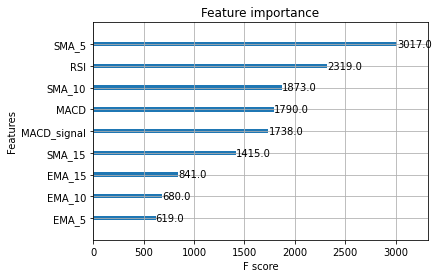

In [83]:
# First we need some technical indicators
data['SMA_5'] = data['Close'].rolling(5).mean().shift()
data['SMA_10'] = data['Close'].rolling(10).mean().shift()
data['SMA_15'] = data['Close'].rolling(15).mean().shift()
data['EMA_5'] = data['Close'].ewm(5).mean().shift()
data['EMA_10'] = data['Close'].ewm(10).mean().shift()
data['EMA_15'] = data['Close'].ewm(15).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=data.index, y=data.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=data.index, y=data.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=data.index, y=data.EMA_5, name='EMA 5'))
fig.add_trace(go.Scatter(x=data.index, y=data.EMA_10, name='EMA 10'))
fig.add_trace(go.Scatter(x=data.index, y=data.EMA_15, name='EMA 15'))
fig.add_trace(go.Scatter(x=data.index, y=data.Close, name='Close'))
fig.show()

# We would also like a Relative strength index (RSI) indicator to predict whether a stock is overbought/oversold
# An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%. (https://www.investopedia.com/terms/r/rsi.asp)
def relative_strength_idx(df, n=10):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

data['RSI'] = relative_strength_idx(data).fillna(0)

fig = go.Figure(go.Scatter(x=data.index, y=data.RSI, name='RSI'))
fig.show()

# Let's also use a moving average convergence/divergence (MACD)
EMA_12 = pd.Series(data['Close'].ewm(span=12, min_periods=12).mean())
EMA_24 = pd.Series(data['Close'].ewm(span=24, min_periods=24).mean())
data['MACD'] = pd.Series(EMA_12 - EMA_24)
data['MACD_signal'] = pd.Series(data.MACD.ewm(span=10, min_periods=10).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=EMA_24, name='EMA 24'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

# Shift label column
# Because we want to predict the next day price, after calculating all features for the current day , we shift Close price column by -1 rows. 
# Now we have features from the current day, but the price from the upcoming day.
data['Close'] = data['Close'].shift(-1)

# Drop invalid samples
# Because of our indicators and shifting label column, a few rows will have invalid values
# Moreover, after shifting Close price column, close price of last row is equal to 0 which is not true. 
# We need to remove/fix these.

data = data.iloc[33:] # Because of moving averages and MACD line
data = data[:-1]      # Because of shifting close price

# # This model needs validation data as well as train and test, so let's take the year 2015 out from train and instead use it for validation (initial strategy)
# date_split_1 = '2015-01-01'
# date_split_2 = '2016-01-01'
# train_XG = data[:date_split_1]
# val_XG = data[date_split_1:date_split_2]
# test_XG = data[date_split_2:]

# This model needs validation data as well as train and test, so let's set up a train-val-test split (new strategy)
test_size  = 0.15
val_size = 0.15

test_split_idx  = int(data.shape[0] * (1-test_size))
val_split_idx = int(data.shape[0] * (1-(val_size+test_size)))

train_XG  = data[:val_split_idx].copy()
val_XG = data[val_split_idx+1:test_split_idx].copy()
test_XG  = data[test_split_idx+1:].copy()

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_XG.index, y=train_XG.Close, name='Training'))
fig.add_trace(go.Scatter(x=val_XG.index, y=val_XG.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_XG.index,  y=test_XG.Close,  name='Test'))
fig.show()

# We also no longer need any data in any of these dataframes except 'Close' and our new technical indicators, so let's drop the necessary columns

# Drop date column, replace it with an actual index
train_XG.index = range(len(train_XG))
val_XG.index = range(len(val_XG))
test_XG.index = range(len(test_XG))

# Drop the rest of the necessary columns
drop_cols = ['Open', 'Low', 'High']
train_XG = train_XG.drop(drop_cols, 1)
val_XG = val_XG.drop(drop_cols, 1)
test_XG  = test_XG.drop(drop_cols, 1)

# View our new datasets
print(train_XG.head())
print(val_XG.head())
print(test_XG.head())

# Now we can finally start experimenting with the model
# First we need to split into features and labels
y_train = train_XG['Close'].copy()
x_train = train_XG.drop(['Close'], 1)

y_valid = val_XG['Close'].copy()
x_valid = val_XG.drop(['Close'], 1)

y_test  = test_XG['Close'].copy()
x_test  = test_XG.drop(['Close'], 1)

x_train.info()

# Now we can fine-tune XGBoostRegressor parameters
parameters = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [8, 10, 12, 14, 16],
    'gamma': [0.001, 0.005, 0.01, 0.015, 0.02],
    'random_state': [42]
}


# Create the model
eval_set = [(x_train, y_train), (x_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)

# Perform the experiments
clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(x_train, y_train, eval_set=eval_set, verbose=False)

# How important were each of the parameters used? (ie. calculate and graph F-scores)
xgb.plot_importance(model)

# Finally time to make predictions
y_pred = model.predict(x_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
predicted_prices = data[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

# Display the results
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data.Close,
                         name='Actual',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Predicted',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_test,
                         name='Actual',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         name='Predicted',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.show()





